In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Timedelta, Timestamp
from collections import namedtuple
from scipy import stats
from scipy.interpolate import InterpolatedUnivariateSpline

plt.style.use("bmh")
from IPython.core.debugger import set_trace

In [41]:
df = pd.read_csv("DATA/eventos.csv",parse_dates=["start","duration"])

df.dropna(how="any", axis=0,inplace=True)

In [42]:
df.duration = df.duration.apply(pd.to_timedelta)

In [43]:
df.head()

,start,station,duration,Pluviometro,RADAR,ERROR
0,2016-10-14 08:20:00,MB_ANHA1,00:30:00,3.00,1.505884,1.494116
1,2016-10-14 09:20:00,MB_ANHA1,01:20:00,4.25,2.097585,2.152415
3,2016-10-20 16:10:00,MB_ANHA1,00:30:00,9.75,0.880495,8.869505
4,2016-10-20 19:10:00,MB_ANHA1,01:30:00,8.00,2.602351,5.397649
5,2016-10-23 14:50:00,MB_ANHA1,01:10:00,20.75,2.136086,18.613914


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 6041
Data columns (total 6 columns):
start          4410 non-null datetime64[ns]
station        4410 non-null object
duration       4410 non-null timedelta64[ns]
Pluviometro    4410 non-null float64
RADAR          4410 non-null float64
ERROR          4410 non-null float64
dtypes: datetime64[ns](1), float64(3), object(1), timedelta64[ns](1)
memory usage: 241.2+ KB


In [46]:
MARCO = 3
df_marco = df[df.start.dt.month == MARCO]
df_marco.head()

,start,station,duration,Pluviometro,RADAR,ERROR
69,2017-03-01 15:00:00,MB_ANHA1,00:20:00,2.3125,3.543831,-1.231331
70,2017-03-05 15:00:00,MB_ANHA1,01:00:00,15.8750,49.031661,-33.156661
71,2017-03-05 16:50:00,MB_ANHA1,00:50:00,0.8125,3.534253,-2.721753
72,2017-03-06 19:30:00,MB_ANHA1,00:10:00,1.0625,0.072933,0.989567
73,2017-03-10 15:40:00,MB_ANHA1,00:50:00,6.2500,15.175746,-8.925746


In [47]:
quantiles = [0, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 60, 75, 100]

In [94]:
radar = stats.gamma(*stats.gamma.fit(df_marco.RADAR))
pluvi = stats.gamma(*stats.gamma.fit(df_marco.Pluviometro))

corrected_quantiles = pluvi.ppf(radar.cdf(quantiles[1:]))

radar_cdf  = radar.cdf(quantiles[1:])
pluvi_cdf = pluvi.cdf(quantiles[1:])

In [95]:
itp_radar_cdf = InterpolatedUnivariateSpline(corrected_quantiles, radar_cdf, k=3)
itp_pluvi_ppf = InterpolatedUnivariateSpline(pluvi_cdf, corrected_quantiles, k=3)



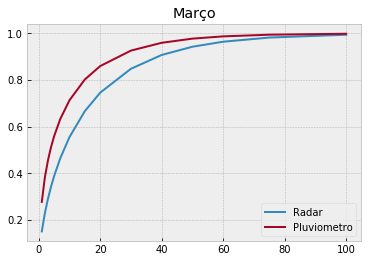

In [96]:
plt.figure()

plt.title("Março")
plt.plot(quantiles[1:], radar_cdf,label="Radar")
plt.plot(quantiles[1:], pluvi_cdf,label="Pluviometro")

plt.legend()

In [97]:
meses = ["Janeiro",
"Fevereiro",
"Março",
"Abril",
"Maio",
"Junho",
"Julho",
"Agosto",
"Setembro",
"Outubro",
"Novembro",
"Dezembro"]

In [108]:
def save_graph(radar_cdf, pluvi_cdf, month):
    plt.figure()

    n_month = meses[month-1]
    plt.title(n_month)
    plt.plot(quantiles[1:], radar_cdf,label="Radar")
    plt.plot(quantiles[1:], pluvi_cdf,label="Pluviometro")

    name = "IMAGENS/CDFs/{}.png".format(month)
    plt.legend()
    plt.savefig(name)

/home/rossuna/anaconda3/envs/ic/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


11
12


/home/rossuna/anaconda3/envs/ic/lib/python3.6/site-packages/numpy/lib/function_base.py:1946: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/home/rossuna/anaconda3/envs/ic/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:598: RuntimeWarning: invalid value encountered in greater
  if not all(diff(x) > 0.0):


1
2
4
5
8
6
9


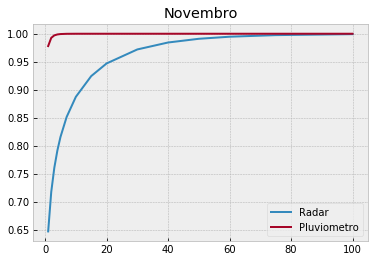

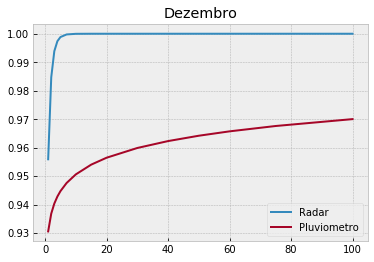

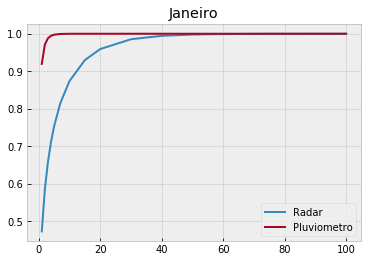

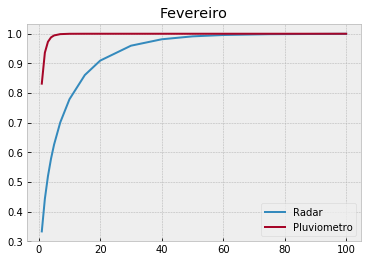

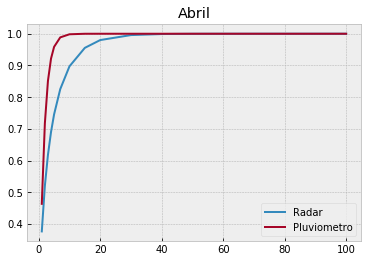

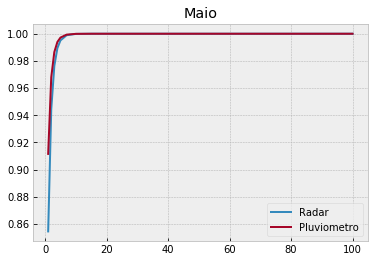

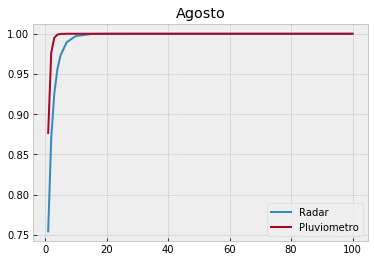

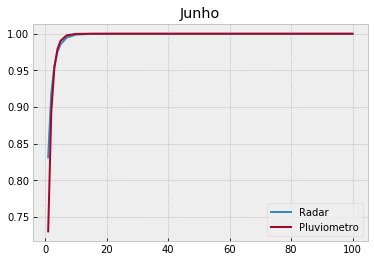

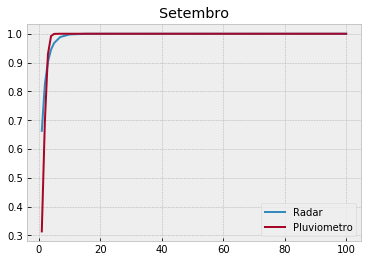

In [113]:
months = df.start.dt.month.unique()
for month in months:
    df_month = df[df.start.dt.month == month]
    quantiles = [0, 1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 60, 75, 100]
    
    radar = stats.gamma(*stats.gamma.fit(df_month.RADAR))
    pluvi = stats.gamma(*stats.gamma.fit(df_month.Pluviometro))
    
    corrected_quantiles = pluvi.ppf(radar.cdf(quantiles[1:]))
    
    radar_cdf  = radar.cdf(quantiles[1:])
    pluvi_cdf = pluvi.cdf(quantiles[1:])
    try:
        itp_radar_cdf = InterpolatedUnivariateSpline(corrected_quantiles, radar_cdf, k=3)
        itp_pluvi_ppf = InterpolatedUnivariateSpline(pluvi_cdf, corrected_quantiles, k=3)

        df_month["RADAR_CORRECTED"] = itp_pluvi_ppf(itp_radar_cdf(df_month.RADAR))

        
    except ValueError:
        save_graph(radar_cdf,pluvi_cdf,month)
        print(month)
    